In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import scipy.fft as spft
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import torch
import torch.fft as fft
from torch import nn

In [ ]:

def fetch_data(file,datacols,cuts,setdevs):

    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    # 26/02/2024: inverse the logic, keep the read and remove the set
    setdevs = ['L:%s_'%d for d in setdevs]
    cols = [col for col in cols if col not in setdevs]

    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter|stamp')),axis=1, inplace=True)

    # apply data quality cuts
    if len(cuts)>0:
        subset.query(cuts,inplace=True)

    subset.dropna(inplace=True)

    return subset


In [ ]:
def load_BPMphase_data_single(cavs,files,dropdevs,scan=True):
    dfs = []
    for i, file in enumerate(files):
        if scan:
            #26/02/2024: inverse the logic, keep the read and remove the set
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',['%s_S'%cavs[i][2:]])
        else:
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',[])
        try:
            df = df.drop(list(df.filter(regex=r'20|B:|SS|SQT')), axis=1)
            df = df.drop(list(df.filter(regex=r'|'.join(dropdevs))),axis=1)
        except:
            continue
        #deal with phase jumps at +-180
        for col in df.columns:
            if abs(df[col].min()-df[col].max())>350:
                #df[col] = np.unwrap(df[col],period=360)
                if np.sign(df[col]).mean() <0:
                    df[col] = df[col].apply(lambda x : x if x < 0 else x -360)
                else:
                    df[col] = df[col].apply(lambda x : x if x > 0 else x +360)

        dfs.append(df)

    return dfs


In [ ]:
def load_BPMphase_data_multi(cavs,files,dropdevs,scan=True):
    dfs = []
    for i, file in enumerate(files):
        if scan:
            # 26/02/2024: inverse the logic, keep the read and remove the set
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',['%s_S'%cav[2:] for cav in cavs])
        else:
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',[])
        try:
            df = df.drop(list(df.filter(regex=r'20|B:|SS|SQT')), axis=1)
            df = df.drop(list(df.filter(regex=r'|'.join(dropdevs))),axis=1)
        except:
            continue
        #deal with phase jumps at +-180
        for col in df.columns:
            if abs(df[col].min()-df[col].max())>350:
                #df[col] = np.unwrap(df[col],period=360)
                if np.sign(df[col]).mean() <0:
                    df[col] = df[col].apply(lambda x : x if x < 0 else x -360)
                else:
                   df[col] = df[col].apply(lambda x : x if x > 0 else x +360)


        dfs.append(df)

    return dfs


In [ ]:
def fft_array(array):
    array = torch.tensor(array, dtype=torch.float32)
    fft_vals = fft.fft(array)
    N = len(array)
    freq = fft.fftfreq(N)
    return freq, fft_vals

def apply_FFT(ddfs):
    raw_ffts = []
    for j in range(len(ddfs)):
        fft_df = ddfs[j].copy(deep=True)
        for current_device in ddfs[j].columns:
            freq, fft_vals = fft_array(ddfs[j][current_device].values)
            fft_df[current_device] = torch.abs(fft_vals).numpy()
            fft_df[f'freq_{current_device}'] = freq.numpy()
        raw_ffts.append(fft_df)
    return raw_ffts

def apply_FFT_filter(df, cavs, BPM_list, tolerance=0.0005):
    ddfs2 = []
    BPMs = list(set(BPM_list).intersection(set(list(df.columns))))
    for j in range(len(cavs)):
        current_df = df.copy(deep=True)
        freq_driving, fft_vals_driving = fft_array(df[cavs[j]].values)
        filter_freqs = freq_driving[torch.argmax(torch.abs(fft_vals_driving))]
        for current_device in BPMs:
            freq, fft_vals = fft_array(df[current_device].values)
            fft_vals2 = torch.zeros_like(fft_vals)
            mask = torch.abs(torch.abs(freq) - filter_freqs) < tolerance
            fft_vals2[mask] = fft_vals[mask]
            current_df[current_device] = torch.real(fft.ifft(fft_vals2)).numpy()
        ddfs2.append(current_df)
    return ddfs2

In [ ]:
def plot_fft(fft_data,devices,npt,nperiods):
    #%matplotlib widget
    %matplotlib inline
    for dev in devices:
        #plt.stem(fft_data['freq_%s'%dev]*npt*nperiods,fft_data['%s'%dev]*2/(npt*nperiods),label='%s'%dev[2:],markerfmt='o')
        markerline, stemlines, baseline = plt.stem(fft_data['freq_%s'%dev]*npt*nperiods,fft_data['%s'%dev]*2/(npt*nperiods),label='%s'%dev[2:],markerfmt='.')
        plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
        plt.setp(baseline, 'color', plt.getp(markerline,'color'))
        plt.setp(stemlines, 'linestyle', 'dotted')


    plt.xlim(0,100)
    plt.ylim(0,6)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude (deg)')
    plt.grid()
    plt.legend(loc='upper right')

In [45]:
def calc_errors(fft_data, devices, npt, nperiods):
    for dev in devices:
        idx_noise = torch.where((fft_data[f'freq_{dev}'] > 0.1) & (fft_data[f'freq_{dev}'] < 0.2))
        noise = torch.mean(torch.tensor(fft_data[dev].iloc[idx_noise].values))

def calc_response_matrix(dfs, cavs):
    final_response_matrix = []
    for j in range(len(dfs)):
        slice_pos = torch.argmax(torch.tensor(dfs[j][cavs[j]].values)).item()
        norm_val = dfs[j][cavs[j]].iloc[slice_pos]
        final_response_matrix.append(dfs[j].iloc[slice_pos] / norm_val)
    return final_response_matrix

In [ ]:
###  BASIS SELECTION
def select_basis(final_response_matrix,basis_choice_override):

    #basis_choice_override = (0, 1) #whether to autoselect basis or not
    possible_basis = list(itertools.combinations(range(len(final_response_matrix)), 7))
    e_normed_response = [response_matrix/np.linalg.norm(response_matrix) for response_matrix in final_response_matrix]
    overlaps = [np.dot(e_normed_response[b[0]], e_normed_response[b[1]]) for b in possible_basis]

    basis_choice = possible_basis[np.argmin(np.abs(overlaps))]

    if basis_choice_override != None: basis_choice = basis_choice_override

    return basis_choice

In [52]:
####  DIAGNOSTICS

def show_basis_choices(final_response_matrix):
    possible_basis = list(itertools.combinations(range(len(final_response_matrix)), 2))
    e_normed_response = [response_matrix/np.linalg.norm(response_matrix) for response_matrix in final_response_matrix]
    overlaps = [np.dot(e_normed_response[b[0]], e_normed_response[b[1]]) for b in possible_basis]

    for i in range(len(possible_basis)): print(possible_basis[i], overlaps[i])
    return None

def plot_tank_fit(cavs,target_index, basis, response_matrix):
    target = response_matrix[target_index]

    idx = len(response_matrix)
    coefs = linear_fit_to_basis(target[idx:], response_matrix[basis[0]][idx:], response_matrix[basis[1]][idx:])
    plt.plot(target[idx:], label = '%s'%cavs[target_index])
    plt.plot(coefs[0] * response_matrix[basis[0]][idx:] + coefs[1] * response_matrix[basis[1]][idx:], label = f"%.4f * T{basis[0]} + %.4f * T{basis[1]}"%tuple(coefs))
    plt.ylabel(r"$ \Delta \phi_{BPM}$ (deg)")
    plt.xticks(rotation = 90)
    plt.xlabel("Distance, m")
    plt.legend()
    return None

def plot_fit_traj(cavs,target_trajectory, basis, response_matrix,targetlbl=None):
    if targetlbl:
        target = str(targetlbl)
    else:
        target='Target trajectory'
    idx = len(response_matrix)
    if len(basis)!=7:
        raise ValueError('The basis length must be 7')
    tensor_b_vecs = [torch.tensor(response_matrix[b][idx:].values, dtype=torch.float32) for b in basis]
    target_tensor = torch.tensor(target_trajectory.values, dtype=torch.float32)
    coefs,bias = linear_fit_to_basis(target_tensor, *tensor_b_vecs)

    plt.plot(dist_data,target_trajectory, label = target)
    fit_line = 0
    for i in range(len(basis)):
        fit_line +=  coefs[i] * response_matrix[basis[i]][idx:]
    fit_line += bias
    #label = " + ".join([f"{coefs[i]:.2f} * {cavs[basis[i]]}" for i in range(len(basis))])
    plt.plot(dist_data,fit_line)
    plt.ylabel(r"$ \Delta \phi_{BPM}$ (deg)")
    plt.xlabel("Distance, m")
    plt.legend(loc='upper right')
    return None


def plot_basis_vectors(response_matrix,cavs,show):
    cavnames = ['Buncher','Tank 1','Tank 2','Tank 3','Tank 4','Tank 5','RFQ']
    e_normed_response = [response_matrix/np.linalg.norm(response_matrix) for response_matrix in response_matrix]
    for index in show:
        plt.plot(dist_data, response_matrix[index][:], label = '%s'%cavnames[index])
    plt.legend(loc='upper right',ncol=2)
    plt.xlabel("Distance, m")
    plt.ylabel(r"$ \Delta \phi_{BPM}$ (deg)")
    #plt.ylim(-0.45, 0.45)
    plt.ylim(-3.5,3.5)
    plt.grid()
    plt.show()

    return None


In [ ]:
### Load BPM location data
json_file = open('/content/drive/MyDrive/PhaseCompensation/sensor_positions.json')
BPM_positions = json.load(json_file)

devices_to_drop = [ 'L:BPM2OF','L:BPM3IF','L:BPM3OF','L:BPM5IF',"L:BPM4IF","L:BPM5OF","L:D44BF"] #remove DTL part & D44 noisy

for device in devices_to_drop:
    try:
        del BPM_positions[device]
    except:
        continue

BPM_list = list(BPM_positions.keys())
dist_data = list(BPM_positions.values())
print(BPM_list)

['L:D02BF', 'L:D03BF', 'L:D11BF', 'L:D12BF', 'L:D13BF', 'L:D21BF', 'L:D22BF', 'L:D23BF', 'L:D31BF', 'L:D32BF', 'L:D33BF', 'L:D34BF', 'L:D41BF', 'L:D42BF', 'L:D43BF', 'L:D51BF', 'L:D52BF', 'L:D53BF', 'L:D54BF', 'L:D61BF', 'L:D62BF', 'L:D63BF', 'L:D64BF', 'L:D71BF', 'L:D72BF', 'L:D73BF', 'L:D74BF']


In [ ]:
print(BPM_positions)

{'L:D02BF': 80.4, 'L:D03BF': 80.9, 'L:D11BF': 83.7, 'L:D12BF': 85.4, 'L:D13BF': 87.1, 'L:D21BF': 90.5, 'L:D22BF': 92.3, 'L:D23BF': 94.2, 'L:D31BF': 98.1, 'L:D32BF': 100.1, 'L:D33BF': 102.2, 'L:D34BF': 104.2, 'L:D41BF': 106.3, 'L:D42BF': 108.5, 'L:D43BF': 110.6, 'L:D51BF': 115.1, 'L:D52BF': 117.3, 'L:D53BF': 119.6, 'L:D54BF': 121.9, 'L:D61BF': 124.3, 'L:D62BF': 126.7, 'L:D63BF': 129.1, 'L:D64BF': 131.5, 'L:D71BF': 133.9, 'L:D72BF': 136.4, 'L:D73BF': 138.9, 'L:D74BF': 141.4}


In [ ]:
# Define filepath and scanned cavities
filepath = r"/content/drive/MyDrive/PhaseCompensation/"

# Cavity colloquial names (for plot labeling)
cavnames = ['Buncher','Tank 1','Tank 2','Tank 3','Tank 4','Tank 5','RFQ']
# Phase setting - this is the control knob
cavs = ['L:RFBPAH', 'L:V1QSET', 'L:V2QSET', 'L:V3QSET', 'L:V4QSET', 'L:V5QSET','L:RFQPAH']
# Phase readback - data from physical phase pickups. Discrepances between the two are sign of mis- or under- regulation
cavs_read = ['L:V%iSQ'%n for n in range(1,6)]
# Combined list
cavs_both = cavs + cavs_read

In [ ]:
# Reference file: this is used to calculate the fit basis

ref_file = r'%s20240229_143636_AllTanks.csv'%filepath
#ref_file = r'%s2024_02_15_1200.csv'%filepath
#ref_file = r'%s20240410_150201.csv'%filepath

reference = load_BPMphase_data_multi(cavs_both,[ref_file],devices_to_drop,scan=True)
reference = [df - df.mean() for df in reference] # mean - for zero peak suppression in FFT


In [ ]:
reference[0].columns

Index(['L:RFQPAH', 'L:RFBPAH', 'L:V1QSET', 'L:V2QSET', 'L:V3QSET', 'L:V4QSET',
       'L:V5QSET', 'L:V1SQ', 'L:V2SQ', 'L:V3SQ', 'L:V4SQ', 'L:V5SQ', 'L:D02BF',
       'L:D03BF', 'L:D11BF', 'L:D12BF', 'L:D13BF', 'L:D21BF', 'L:D22BF',
       'L:D23BF', 'L:D31BF', 'L:D32BF', 'L:D33BF', 'L:D34BF', 'L:D41BF',
       'L:D42BF', 'L:D43BF', 'L:D51BF', 'L:D52BF', 'L:D53BF', 'L:D54BF',
       'L:D61BF', 'L:D62BF', 'L:D63BF', 'L:D64BF', 'L:D71BF', 'L:D72BF',
       'L:D73BF', 'L:D74BF'],
      dtype='object')

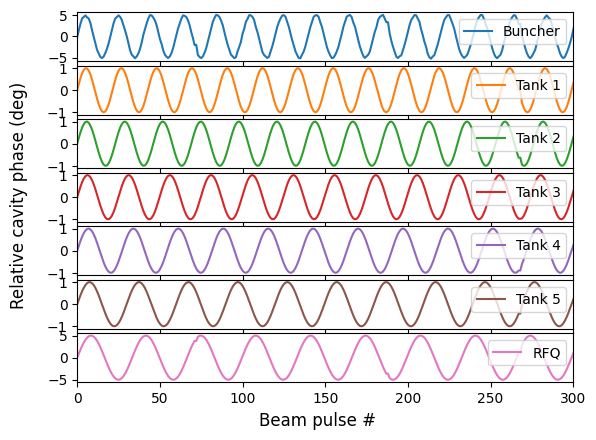

In [ ]:
# For demonstration: how are we changing cavity phases?
# Oscillating them all together in sinewaves with different frequencies
%matplotlib inline
fig,ax = plt.subplots(7,sharex=True)
colors = [p['color'] for p in plt.rcParams['axes.prop_cycle']]

for i, cav in enumerate(cavs[:7]):
    ax[i].plot(reference[0][cav],label='%s'%cavnames[i],c=colors[i])
    ax[i].legend(loc='upper right',bbox_to_anchor=(1,1))
    ax[i].set_xlim(0,300)

fig.supxlabel('Beam pulse #')
fig.supylabel('Relative cavity phase (deg)')
plt.subplots_adjust(wspace=0, hspace=0.1)

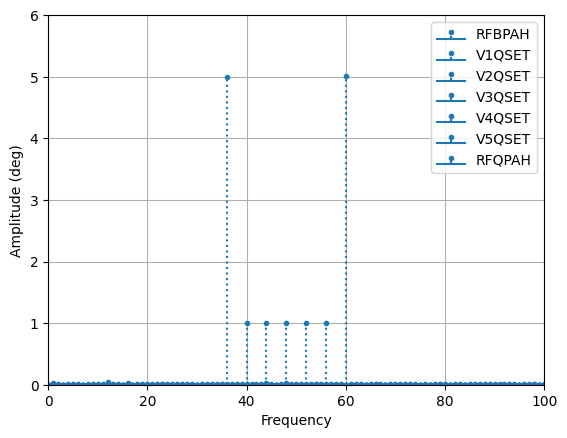

In [ ]:
# Sanity check in Fourier space: are cavity phases oscillating at the desired frequencies and amplitudes?
raw_ffts = apply_FFT(reference)

Nper = 4
Npt = 299
plot_fft(raw_ffts[0],cavs,Npt,Nper)

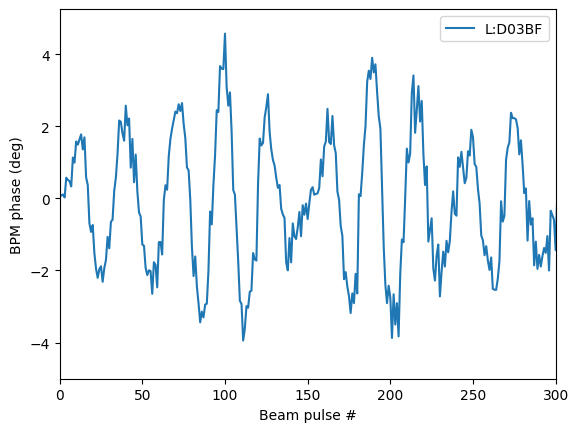

In [ ]:
# For demonstration purposes.
# What does the beam phase combined response look like? It is the combined effect of 7 cavities oscillating
# L:D03BF is the data from one sensor
plt.plot(reference[0]['L:D03BF'],label='L:D03BF')
#plt.plot(dfs[0]['L:D12BF'],label='L:D12BF') # different location
plt.xlim(0,300)
plt.xlabel('Beam pulse #')
plt.ylabel('BPM phase (deg)')
plt.legend()

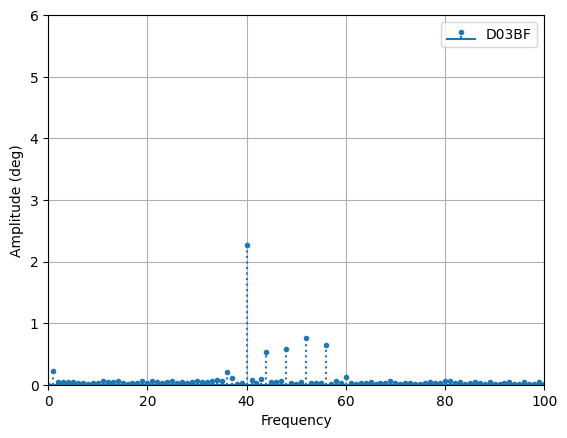

In [ ]:
# And here is the response in Fourier space.
# We see 7 peaks corresponding to the 7 cavities + noise
plot_fft(raw_ffts[0],['L:D03BF'],Npt,Nper)

In [ ]:
# select only relevant columns from dataframe
reference[0] = reference[0][cavs+BPM_list]
reference[0].columns

Index(['L:RFBPAH', 'L:V1QSET', 'L:V2QSET', 'L:V3QSET', 'L:V4QSET', 'L:V5QSET',
       'L:RFQPAH', 'L:D02BF', 'L:D03BF', 'L:D11BF', 'L:D12BF', 'L:D13BF',
       'L:D21BF', 'L:D22BF', 'L:D23BF', 'L:D31BF', 'L:D32BF', 'L:D33BF',
       'L:D34BF', 'L:D41BF', 'L:D42BF', 'L:D43BF', 'L:D51BF', 'L:D52BF',
       'L:D53BF', 'L:D54BF', 'L:D61BF', 'L:D62BF', 'L:D63BF', 'L:D64BF',
       'L:D71BF', 'L:D72BF', 'L:D73BF', 'L:D74BF'],
      dtype='object')

In [54]:
# Calculate and plot response matrix: how beam phase changes in response to cavity phase change
refs = apply_FFT_filter(reference[0],cavs,BPM_list,tolerance=0.0001)
response_matrix = calc_response_matrix(refs,cavs)

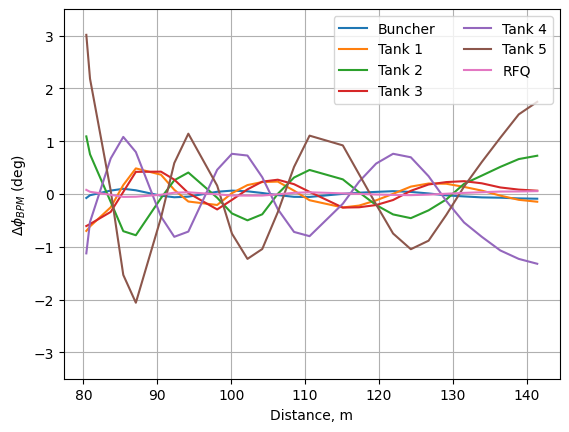

In [ ]:
%matplotlib inline
response_matrix_bpm = [r[BPM_list] for r in response_matrix]
plot_basis_vectors(response_matrix_bpm,cavs,range(len(response_matrix_bpm)))

In [ ]:
# Select 2 basis vectors out of the 7
show_basis_choices(response_matrix_bpm)
#basis_choice = select_basis(response_matrix_bpm,basis_choice_override=(0,1))
# we can force the choice of basis vectors. If not forced, it will look for "orthogonality" (see function body)
basis_choice = select_basis(response_matrix_bpm,basis_choice_override=None)
# basis_choice=(1,3)

(0, 1) 0.2652983544906456
(0, 2) -0.8683836829642168
(0, 3) -0.14570015018823404
(0, 4) 0.9861924642242741
(0, 5) -0.7651170995441031
(0, 6) -0.8991281080922735
(1, 2) -0.6957492240136764
(1, 3) 0.9083621957099772
(1, 4) 0.34483870476703166
(1, 5) -0.8160941057873199
(1, 6) -0.6407444959757235
(2, 3) -0.3460615351674245
(2, 4) -0.9113747768012356
(2, 5) 0.98051342448257
(2, 6) 0.9814399067528565
(3, 4) -0.0681131121466905
(3, 5) -0.5077657979541684
(3, 6) -0.2798153805287206
(4, 5) -0.8227578867543179
(4, 6) -0.920984134413479
(5, 6) 0.9512766698520375


In [ ]:
print(basis_choice)

(0, 1, 2, 3, 4, 5, 6)


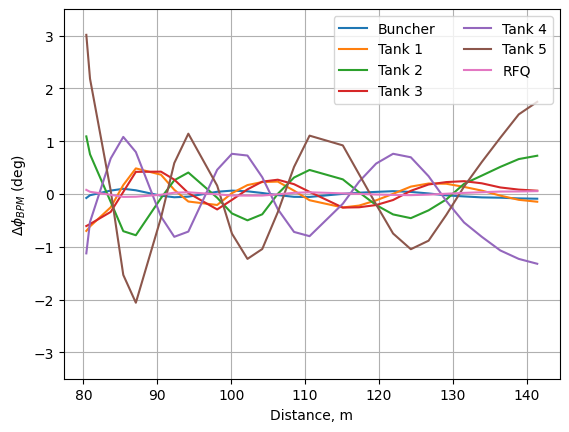

In [ ]:
# Sanity check
plot_basis_vectors(response_matrix_bpm,cavs,list(basis_choice))

In [ ]:

### Fitting with basis vectors demonstration
# Below we show several tests of the 2-vector fitting

# Test 1: 1-step drift compensation
# Fitting data from Feb 15 and Feb21 to return to Feb 08 state
# Reference file: Feb 29 (I think?)
path = "/content/drive/MyDrive/PhaseCompensation/"
dates = ["20240208_","20240215_","20240215_","20240221_","20240221_"]
times = ["163623_nominal",'143017_nominal2',
         "155508_dailyCorrFeb8_positive","161542_nominal2","162307_dailyCorrFeb8_negative2"]
files = ['%s%s%s.csv'%(path,d,t) for (d,t) in zip(dates,times)]
lbls = ['Feb 08 nominal','Feb 15 relative','Feb 15 corrected','Feb 21 relative','Feb 21 corrected']



# Test 2: 1-step compensation of upstream fluctuation
# Reference file Feb 15
# date="20240215_"
# lbls = ['Nominal','RFQ +15deg','RFQ Compensated','T1+4deg','T1 Compensated']
# times = ['132713_nominal_1000evt','133256_RFQplus15deg','134353_FullyCompensatedT4T5',
#          '143412_T1plus4deg','144019_T1FullyCompensatedT4T5']
# files = [r'%s%s%s.csv'%(filepath,date,t) for t in times]


# Test 3: multi-step compensation of upstream fluctuations
# Reference file April 10
# date = '20240410_'
# lbls = ['Nominal','Buncher+20deg','Compensated step 1','Step 2','Step 3','Step 4']
# times = ['151457','152154','155113','160055','160739','161432']
# files = [r'%s%s%s.csv'%(filepath,date,t) for t in times]


dfs = load_BPMphase_data_multi(cavs_both,files,devices_to_drop,scan=False)


In [ ]:
means = [df[BPM_list].mean() for df in dfs]
stds = [df[BPM_list].std() for df in dfs] #normalized by N-1. Use ddof=0 to normalize by N
#should I be using SEM instead of STD?

In [ ]:
# Calculate difference from nominal
diffs = [m - means[0] for m in means]
errs = [np.sqrt(s**2 + stds[0]**2) for s in stds]

In [69]:
#Linear MLP

class DeepNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepNN, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        embedding = self.encoder(X)
        output = self.decoder(embedding)
        return embedding, output

def linear_fit_to_basis(osc_array, *b_vecs):
    X = torch.stack(b_vecs, dim=1)
    X=X.view(-1)
    if not isinstance(osc_array, torch.Tensor):
        osc_array = torch.tensor(osc_array, dtype=torch.float32)
    if osc_array.ndim == 1:
        osc_array = osc_array.unsqueeze(1)
    osc_array = osc_array.view(-1)
    model = DeepNN(input_dim=X.shape[0], hidden_dim=7, output_dim=osc_array.shape[0])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    loss_fn = nn.SmoothL1Loss(beta=0.1)

    reg_loss = lambda emb: torch.norm(emb, p=2)

    # Training Loop
    print("Linear MLP\n")
    for _ in range(13000):
        optimizer.zero_grad()
        embedding, output = model(X)
        loss = loss_fn(output, osc_array) + 0.5 * reg_loss(embedding)
        if _ % 1000 == 0:
            test_loss = loss_fn(output, osc_array).item()
            output_np = output.detach().numpy()
            osc_array_np = osc_array.detach().numpy()
            r2 = r2_score(osc_array_np, output_np)
            print(f"Epoch {_}: Test Loss: {test_loss}, R² Score: {r2:.4f}")
        loss.backward()
        optimizer.step()
    return model.decoder.weight.detach().numpy().T, model.decoder.bias.detach().numpy()

Linear MLP

Epoch 0: Test Loss: 0.5075482130050659, R² Score: -0.4358
Epoch 1000: Test Loss: 0.14427727460861206, R² Score: 0.6991
Epoch 2000: Test Loss: 0.02707476168870926, R² Score: 0.9646
Epoch 3000: Test Loss: 3.2710515370126814e-05, R² Score: 1.0000
Epoch 4000: Test Loss: 5.656034772982821e-06, R² Score: 1.0000
Epoch 5000: Test Loss: 5.467044502438512e-06, R² Score: 1.0000
Epoch 6000: Test Loss: 2.277320618304657e-06, R² Score: 1.0000
Epoch 7000: Test Loss: 2.1506446046259953e-06, R² Score: 1.0000
Epoch 8000: Test Loss: 5.5030172916303854e-06, R² Score: 1.0000
Epoch 9000: Test Loss: 3.7361799058999168e-06, R² Score: 1.0000
Epoch 10000: Test Loss: 2.0982213300158037e-06, R² Score: 1.0000
Epoch 11000: Test Loss: 4.2950034639943624e-07, R² Score: 1.0000
Epoch 12000: Test Loss: 5.392180355556775e-07, R² Score: 1.0000


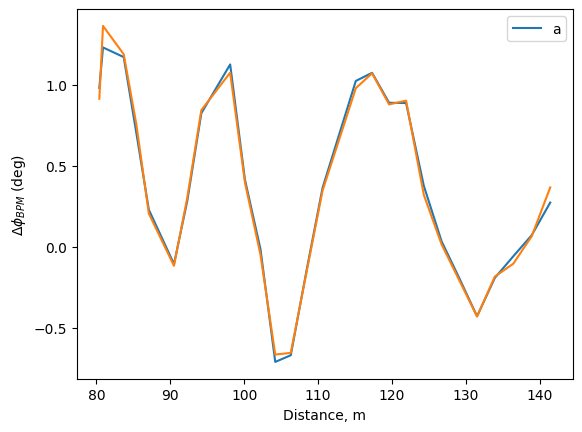

In [70]:
plot_fit_traj(cavs,diffs[1],basis_choice,response_matrix,'a')

Linear MLP

Epoch 0: Test Loss: 0.4655939042568207, R² Score: -0.4101
Epoch 1000: Test Loss: 0.08764280378818512, R² Score: 0.8318
Epoch 2000: Test Loss: 0.006740097422152758, R² Score: 0.9933
Epoch 3000: Test Loss: 1.18006710181362e-05, R² Score: 1.0000
Epoch 4000: Test Loss: 1.109742584048945e-06, R² Score: 1.0000
Epoch 5000: Test Loss: 3.2428508802695433e-06, R² Score: 1.0000
Epoch 6000: Test Loss: 2.0041229618072975e-06, R² Score: 1.0000
Epoch 7000: Test Loss: 3.446794607953052e-06, R² Score: 1.0000
Epoch 8000: Test Loss: 1.4246105592974345e-06, R² Score: 1.0000
Epoch 9000: Test Loss: 1.2818442201023572e-06, R² Score: 1.0000
Epoch 10000: Test Loss: 1.579671561557916e-06, R² Score: 1.0000
Epoch 11000: Test Loss: 1.797693698790681e-06, R² Score: 1.0000
Epoch 12000: Test Loss: 7.089212203936768e-07, R² Score: 1.0000


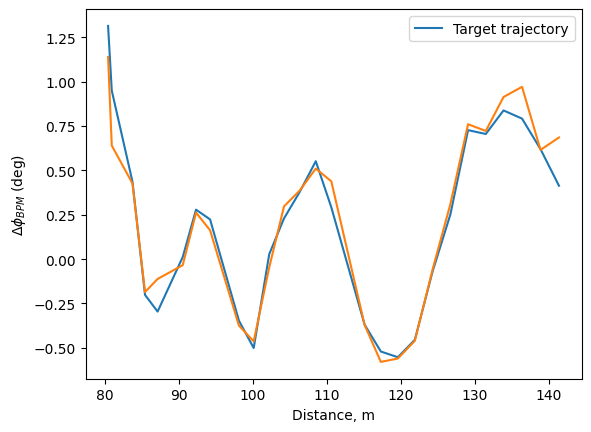

In [71]:
plot_fit_traj(cavs,diffs[-1],basis_choice,response_matrix)

In [74]:
#Non-Linear MLP

class DeepNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU()
        )
        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        embedding = self.encoder(X)
        output = self.decoder(embedding)
        return embedding, output

def linear_fit_to_basis(osc_array, *b_vecs):
    X = torch.stack(b_vecs, dim=1)
    X = X.view(-1)
    if not isinstance(osc_array, torch.Tensor):
        osc_array = torch.tensor(osc_array, dtype=torch.float32)
    if osc_array.ndim == 1:
        osc_array = osc_array.unsqueeze(1)
    osc_array = osc_array.view(-1)
    model = DeepNN(input_dim=X.shape[0], hidden_dim=7, output_dim=osc_array.shape[0])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.SmoothL1Loss(beta=0.1)

    reg_loss = lambda emb: torch.norm(emb, p=2)

    print("Non-Linear MLP\n")
    for _ in range(10000):
        optimizer.zero_grad()
        embedding, output = model(X)
        loss = loss_fn(output, osc_array) + 0.5 * reg_loss(embedding)  # Loss + Regularization
        if _ % 1000 == 0:
            test_loss = loss_fn(output, osc_array).item()
            output_np = output.detach().numpy()
            osc_array_np = osc_array.detach().numpy()
            r2 = r2_score(osc_array_np, output_np)
            print(f"Epoch {_}: Test Loss: {test_loss}, R² Score: {r2:.4f}")

        loss.backward()
        optimizer.step()

    return model.decoder.weight.detach().numpy().T, model.decoder.bias.detach().numpy()

Non-Linear MLP

Epoch 0: Test Loss: 0.5544237494468689, R² Score: -0.6783
Epoch 1000: Test Loss: 0.032706648111343384, R² Score: 0.9555
Epoch 2000: Test Loss: 9.555705764796585e-05, R² Score: 0.9999
Epoch 3000: Test Loss: 3.88269399991259e-05, R² Score: 1.0000
Epoch 4000: Test Loss: 1.8786486180033535e-05, R² Score: 1.0000
Epoch 5000: Test Loss: 2.0055726054124534e-05, R² Score: 1.0000
Epoch 6000: Test Loss: 2.3659922590013593e-05, R² Score: 1.0000
Epoch 7000: Test Loss: 1.4801132692809915e-06, R² Score: 1.0000
Epoch 8000: Test Loss: 2.7718137062038295e-05, R² Score: 1.0000
Epoch 9000: Test Loss: 6.496656510535104e-07, R² Score: 1.0000


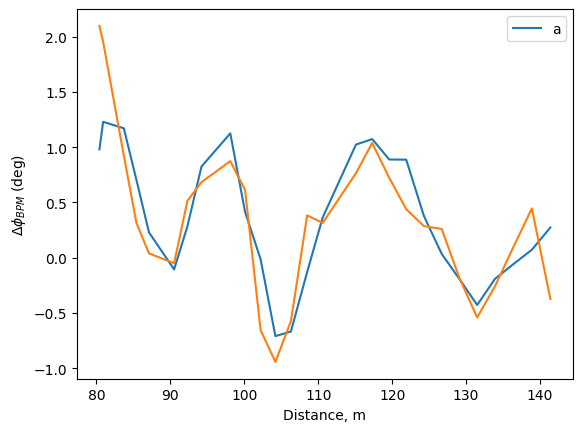

In [75]:
plot_fit_traj(cavs,diffs[1],basis_choice,response_matrix,'a')

Non-Linear MLP

Epoch 0: Test Loss: 0.45082202553749084, R² Score: -0.5621
Epoch 1000: Test Loss: 0.03178999945521355, R² Score: 0.9426
Epoch 2000: Test Loss: 8.316920684592333e-06, R² Score: 1.0000
Epoch 3000: Test Loss: 1.810984940675553e-05, R² Score: 1.0000
Epoch 4000: Test Loss: 8.011184036149643e-06, R² Score: 1.0000
Epoch 5000: Test Loss: 1.427181928193022e-06, R² Score: 1.0000
Epoch 6000: Test Loss: 1.2042285106872441e-06, R² Score: 1.0000
Epoch 7000: Test Loss: 3.703577533542557e-07, R² Score: 1.0000
Epoch 8000: Test Loss: 8.094002623693086e-08, R² Score: 1.0000
Epoch 9000: Test Loss: 1.5831365374197048e-07, R² Score: 1.0000


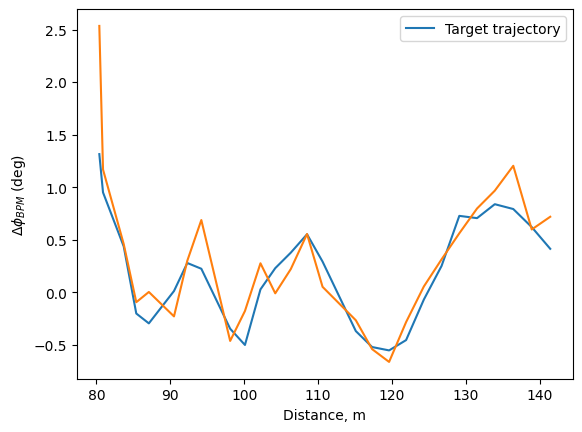

In [76]:
plot_fit_traj(cavs,diffs[-1],basis_choice,response_matrix)

In [61]:
# CNN + MLP

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # CNN Encoder (Downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # (27x7) -> (27x7)
            nn.LeakyReLU(),
            nn.MaxPool2d((3, 1)),  # (27x7) -> (9x7)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (9x7) -> (9x7)
            nn.LeakyReLU(),
            nn.MaxPool2d((3, 1)),  # (9x7) -> (3x7)
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),  # (3x7) -> (3x7)
            nn.LeakyReLU()
        )

        self.fc_encode = nn.Linear(3 * 7, 7)  # Fully Connected Layer: (3x7) → 7D

        # CNN Decoder (Upsampling)
        self.fc_decode = nn.Linear(7, 3 * 7)  # Fully Connected Layer: 7D → (3x7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 32, kernel_size=3, stride=1, padding=1),  # (3x7) -> (3x7)
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=(3, 1)),  # (3x7) -> (9x7)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),  # (9x7) -> (9x7)
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=(3, 1)),  # (9x7) -> (27x7)
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),  # (27x7) -> (27x7)
            nn.LeakyReLU()
        )

    def forward(self, X):
        X = X.unsqueeze(1)
        X = self.encoder(X)
        X = X.view(X.size(0), -1)
        embedding = self.fc_encode(X)

        X = self.fc_decode(embedding)
        X = X.view(X.size(0), 1, 3, 7)
        X = self.decoder(X)
        return embedding, X.squeeze(1)

class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.encoder = nn.Linear(189,7)
        self.decoder = nn.Linear(7,27)

    def forward(self, X):
        X=X.view(-1)
        embedding = self.encoder(X)
        output = self.decoder(embedding)
        return embedding, output

class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.cnn = CNNModel()
        self.fc_nn = FullyConnectedNN()

    def forward(self, X):
        embedding, cnn_output = self.cnn(X)
        embedding, nn_output = self.fc_nn(cnn_output)
        return cnn_output, embedding, nn_output


def linear_fit_to_basis(osc_array, *b_vecs):
    X = torch.stack(b_vecs, dim=1).unsqueeze(0)
    osc_array = torch.tensor(osc_array, dtype=torch.float32).view(1, 27)

    model = CombinedModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    loss_fn = nn.SmoothL1Loss(beta=0.1)

    print("CNN + MLP\n")
    for epoch in range(8000):
        optimizer.zero_grad()
        cnn_output, embedding, nn_output = model(X)
        loss = loss_fn(nn_output, osc_array) + 0.7 * torch.norm(embedding, p=2)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Step {epoch}: Loss = {loss.item():.6f}")

    return model.fc_nn.decoder.weight.detach().numpy().T, model.fc_nn.decoder.bias.detach().numpy()

<ipython-input-61-6f247ba91fa6>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  osc_array = torch.tensor(osc_array, dtype=torch.float32).view(1, 27)


CNN + MLP

Step 0: Loss = 0.624574
Step 500: Loss = 0.350338
Step 1000: Loss = 0.211906
Step 1500: Loss = 0.105203
Step 2000: Loss = 0.048754
Step 2500: Loss = 0.015223
Step 3000: Loss = 0.001900
Step 3500: Loss = 0.000193
Step 4000: Loss = 0.000284
Step 4500: Loss = 0.000217
Step 5000: Loss = 0.000122
Step 5500: Loss = 0.000284
Step 6000: Loss = 0.000308
Step 6500: Loss = 0.000210
Step 7000: Loss = 0.000202
Step 7500: Loss = 0.000166


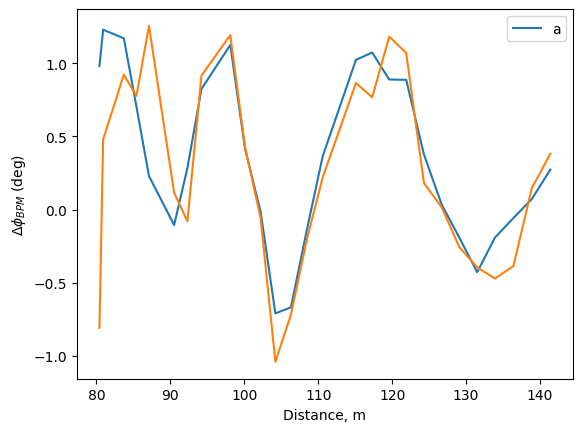

In [64]:
plot_fit_traj(cavs,diffs[1],basis_choice,response_matrix,'a')

<ipython-input-61-6f247ba91fa6>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  osc_array = torch.tensor(osc_array, dtype=torch.float32).view(1, 27)


CNN + MLP

Step 0: Loss = 0.653380
Step 500: Loss = 0.264279
Step 1000: Loss = 0.110490
Step 1500: Loss = 0.043412
Step 2000: Loss = 0.004818
Step 2500: Loss = 0.000499
Step 3000: Loss = 0.000657
Step 3500: Loss = 0.000427
Step 4000: Loss = 0.000856
Step 4500: Loss = 0.000572
Step 5000: Loss = 0.000278
Step 5500: Loss = 0.000330
Step 6000: Loss = 0.000386
Step 6500: Loss = 0.000536
Step 7000: Loss = 0.000477
Step 7500: Loss = 0.000340


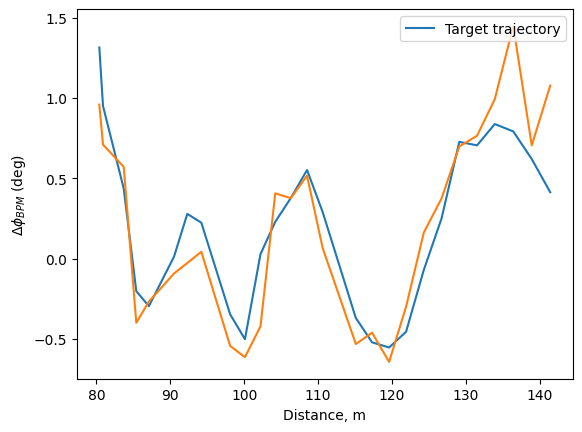

In [63]:
plot_fit_traj(cavs,diffs[-1],basis_choice,response_matrix)

In [65]:
# Metrics
for i,(diff,err) in enumerate(zip(diffs,errs)):
    print(r'%s mean'%lbls[i],diff.mean())
    print(r'%s STD'%lbls[i],diff.std())
    print(r'%s err'%lbls[i],err.mean())
    print(r'%s err/sqrt(N)'%lbls[i],err.mean()/np.sqrt(dfs[i].shape[0]))

Feb 08 nominal mean 0.0
Feb 08 nominal STD 0.0
Feb 08 nominal err 0.492983325064769
Feb 08 nominal err/sqrt(N) 0.015597302158595961
Feb 15 relative mean 0.3502481159544916
Feb 15 relative STD 0.5764942064061145
Feb 15 relative err 0.5076131662988342
Feb 15 relative err/sqrt(N) 0.016060169851392716
Feb 15 corrected mean 0.2922739695261665
Feb 15 corrected STD 0.3107970612688756
Feb 15 corrected err 0.5035463868011051
Feb 15 corrected err/sqrt(N) 0.015923534898396402
Feb 21 relative mean -0.007184648637899011
Feb 21 relative STD 1.3666226788948868
Feb 21 relative err 0.5263273684654922
Feb 21 relative err/sqrt(N) 0.016643932792336374
Feb 21 corrected mean 0.21223127424299232
Feb 21 corrected STD 0.5084061826662281
Feb 21 corrected err 0.5194840182816093
Feb 21 corrected err/sqrt(N) 0.016435746987254227


(-4.0, 4.0)

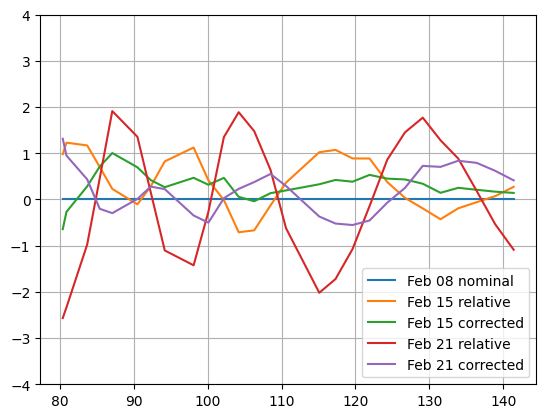

In [66]:
#%matplotlib widget
#[plt.errorbar(dist_data,diff,yerr=err,label=lbls[i]) for i,(diff,err) in enumerate(zip(diffs,errs))];
[plt.plot(dist_data,diff,label=lbl) for (diff,lbl) in zip(diffs[:],lbls[:])];
plt.legend()
plt.grid()
plt.ylim(-4,4)